[View in Colaboratory](https://colab.research.google.com/github/SakshiPriya/cifar10_convnet/blob/master/cifar10.ipynb)

In [1]:
!pip install torch
!pip install torchvision

    100% |████████████████████████████████| 519.5MB 28kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5a31e000 @  0x7fb7332d81c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 2.7MB/s 
    100% |████████████████████████████████| 2.0MB 8.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [8]:
transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
traindataset=torchvision.datasets.CIFAR10(root='drive/app/cifar10',train=True,download=True,transform=transform)#download trainset and transfor it,here dataset already in range 0,1not 0,255
trainset=torch.utils.data.DataLoader(traindataset,batch_size=64,shuffle=True,num_workers=4)#shuffles traindataset and batch it
testdataset=torchvision.datasets.CIFAR10(root='drive/app/cifar10',train=False,download=True,transform=transform)
testset=torch.utils.data.DataLoader(testdataset,batch_size=64,shuffle=True,num_workers=4)
sizeoftrainset=len(traindataset)
sizeoftestset=len(testdataset)
classes = np.array(('airplane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck'))
if torch.cuda.is_available():
  processor='cuda'
else:
  processor='cpu'
 
device=torch.device(processor)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
def show_image(i):
     untransform=torchvision.transforms.ToPILImage()
     i=(i/2+0.5)
     plt.imshow(untransform(i))
 

#sample of trainset
#a=iter(trainset)
#image,labels=a.next()
#plt.figure()
#show_image(torchvision.utils.make_grid(image))#it takes a batch of image and pad every image by 0 and then make a grid of image
#plt.show()
#labels=labels.numpy()
#print(classes[labels])

In [0]:

class classifier(nn.Module):
  def __init__(self):
    super(classifier,self).__init__()
    self.conv1=nn.Conv2d(3,16,5) #filter1
    self.conv2=nn.Conv2d(16,32,5)#filter2
    self.conv3=nn.Conv2d(32,64,5)#filter3
    self.conv4=nn.Conv2d(64,96,3)
    self.conv5=nn.Conv2d(96,128,3)
    self.bc1=nn.BatchNorm2d(16)
    self.bc2=nn.BatchNorm2d(32)
    self.bc3=nn.BatchNorm2d(64)
    self.bc4=nn.BatchNorm2d(96)
    self.bc5=nn.BatchNorm2d(128)
    self.fc1=nn.Linear(3200,700) #linear layer input and output
    self.fc2=nn.Linear(700,100)
    self.fc3=nn.Linear(100,10)
    
    
  def forward(self,x):
    x=self.conv1(x)
    x=self.bc1(x)
    x=f.relu(x)
    x=f.max_pool2d(x,(2,2),stride=1)
    x=self.conv2(x)
    x=self.bc2(x)
    x=f.relu(x)
    x=self.conv3(x)
    x=self.bc3(x)
    x=f.relu(x)
    x=f.max_pool2d(x,(2,2),stride=2)
    x=self.conv4(x)
    x=self.bc4(x)
    x=f.relu(x)
    x=self.conv5(x)
    x=self.bc5(x)
    x=f.relu(x)   

    x=x.view(-1,self.num_of_features(x))
    
    x=f.relu(self.fc1(x))
    x=f.relu(self.fc2(x))
    x=self.fc3(x)
    return x
  
  def num_of_features(self,x):
    size=x.size()[1:]     
    numfeatures=1
    for s in size:
      numfeatures*=s
    return numfeatures
  
  
net=classifier()
net.to(device)
net=nn.DataParallel(net)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=.01,momentum=0.9)
scheduler=optim.lr_scheduler.StepLR(optimizer,gamma=0.1,step_size=30)
dtype=torch.cuda.LongTensor
Losslist=[]

In [14]:
for epoch in range(70):
  running_loss=0.0
  for a,b in enumerate(trainset):
    inputs,labels=b
    labels=labels.type(dtype)
    inputs.to(device)
    labels.to(device)
    optimizer.zero_grad()
    output=net(inputs)
    loss=criterion(output,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
  lossofepoch=running_loss/sizeoftrainset
  print(lossofepoch)
  Losslist.append(running_loss/sizeoftrainset)
  scheduler.step()
  
print("complete")

0.023961814663410186
0.017990345509052277
0.015272923805713653
0.013317236924171447
0.011857324004769325
0.010590534500479698
0.009487243515849113
0.008501282106637954
0.007543810122013092
0.006431637794077396
0.005537695956528187
0.004718330928385257
0.0038010656853020193
0.0032515621392428876
0.0026780353154242037
0.0023310907320678235
0.0017857988278567791
0.0016317694497853517
0.0013691638826578856
0.0012410039315372706
0.0011993272592872382
0.0008107841020822525
0.0008932323287427425
0.0008168010930716991
0.0006809865865856409
0.0007051624898985028
0.0006320415885746479
0.0006776732408255338
0.0004823525030165911
0.00042953657813370226
0.0003267366713285446
0.00011668708920478821
4.8447567522525785e-05
4.023900061845779e-05
2.86313609033823e-05
2.6006563752889634e-05
2.0412494987249374e-05
2.1352894902229308e-05
1.855391100049019e-05
1.574133813381195e-05
1.52009217441082e-05
1.3980846405029296e-05
1.44446462392807e-05
1.2531821578741074e-05
1.3563988357782365e-05
1.28228719532489

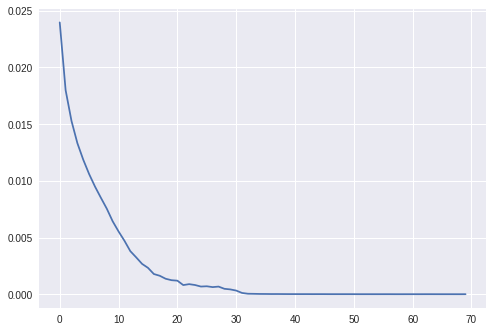

In [15]:
plt.figure()
plt.plot(Losslist)
plt.show()

In [16]:

class_total=np.zeros(10,)
class_correct=np.zeros(10,)

correctsum=0
for i in testset:
   image,label=i
   label=label.type(dtype)
   image.to(device)
   label.to(device)
   output=net(image)
   predict=torch.max(output,1)[1]
   labels=label.cpu().numpy()
   predicts=predict.cpu().numpy()
   unique_elements, counts_elements = np.unique(labels, return_counts=True)
   class_total[unique_elements]+=counts_elements
   correct=(predicts==labels)
   c=[predicts[m] for m,n in enumerate(correct) if n==1]
   uts, cts = np.unique(c, return_counts=True)
   class_correct[uts]+=cts
   correctsum+=correct.sum()
   
print('class accuracy percentage:',class_correct/class_total*100,'\ntotal accuracy:',correctsum/sizeoftestset*100)


class accuracy percentage: [79.6 86.5 67.3 59.2 75.8 65.9 80.6 79.5 85.4 82.9] 
total accuracy: 76.27000000000001
